In [14]:
import numpy as np
import cirq
X = np.array([[0, 1], [1, 0]])
Y = np.array([[0, -1j], [1j, 0]])
Z = np.array([[1, 0], [0, -1]])
I = np.array([[1, 0], [0, 1]])

In [43]:
import cirq
from numpy import pi
import numpy as np
from sympy import Symbol, Matrix
from cirq.contrib.svg import SVGCircuit, circuit_to_svg

sqrtiSWAP = cirq.ISwapPowGate(exponent = 0.5)    
sqrtiSWAPinv = cirq.ISwapPowGate(exponent = -0.5)    

def round(matrix):
    return np.round(matrix,3)

class ParametrisedCircuit(cirq.Gate):
    """
    This circuit parametrises an MPS state using repeated layers of Ry 
    gates and sqrt(iSWAP) gate as are available on Google's device
    """
    def __init__(self, depth, params):
        """
        params = [[Θ1, Θ2],...], 2 params for each layer
        """
        assert len(params) == depth
        self.d = depth
        self.p = params

    def num_qubits(self):
        return 2

    def _decompose_(self, qubits):
        gates = []
        for p in self.p:
            gates += [cirq.ry(p[0]).on(qubits[0]),
                      cirq.ry(p[1]).on(qubits[1]),
                      sqrtiSWAP.on(*qubits)]
        return gates


class K(cirq.Gate):
    def __init__(self, theta):
        self.theta = theta

    def num_qubits(self):
        return 2

    def _decompose_(self, qubits):
        return [
            cirq.rz(-pi/4)(qubits[0]),
            cirq.rz(pi/4)(qubits[1]),
            sqrtiSWAP.on(*qubits),
            cirq.rz(self.theta)(qubits[0]),
            cirq.rz(-self.theta)(qubits[1]),
            sqrtiSWAPinv.on(*qubits),
            cirq.rz(pi/4)(qubits[0]),
            cirq.rz(-pi/4)(qubits[1])
        ]

class expYY(cirq.Gate):
    def __init__(self, gamma):
        self.gamma = gamma

    def num_qubits(self):
        return 2

    def _decompose_(self, qubits):
        return [
            K(self.gamma).on(*qubits),
            cirq.X.on(qubits[1]),
            K(-self.gamma).on(*qubits),
            cirq.X.on(qubits[1])
        ]

class V(cirq.Gate):
    def __init__(self, params):
        self.gamma = params[0]
        self.psi = params[1]
        self.phi = params[2]
    
    def num_qubits(self):
        return 2

    def _decompose_(self, qubits):
        return [
            expYY(self.gamma).on(*qubits),
            cirq.rx(self.psi).on(qubits[1]),
            cirq.rz(self.phi).on(qubits[1])
        ]

class CPHASE(cirq.Gate):
    def __init__(self, phi, alpha, xi_one, xi_two):
        self.phi = phi
        self.alpha = alpha
        self.xi_one = xi_one
        self.xi_two = xi_two

    def num_qubits(self):
        return 2

    def _decompose_(self, qubits):
        return [
            cirq.rz(-self.phi/2)(qubits[0]),
            cirq.rz(-self.phi/2)(qubits[1]),
            cirq.rx(self.xi_one)(qubits[0]),
            cirq.rx(self.xi_two)(qubits[1]),
            sqrtiSWAPinv(*qubits),
            cirq.rx(-2*self.alpha)(qubits[0]),
            sqrtiSWAPinv(*qubits),
            cirq.rx(self.xi_one)(qubits[0]),
            cirq.rx(-self.xi_two)(qubits[1])
        ]

class CPHASEExact(CPHASE):
    def __init__(self, phi):
        self.phi = phi

    def num_qubits(self):
        return 2

    def _decompose_(self, qubits):
        return [cirq.CZPowGate(exponent=self.phi / pi)(*qubits)]

class TFIM(cirq.Gate):
    def __init__(self, J, g, ξ1, ξ2, α):
        self.J = J
        self.g = g
        self.ξ1 = ξ1
        self.ξ2 = ξ2
        self.α = α

    def num_qubits(self):
        return 2

    def _decompose_(self, qubits):
        return [
            cirq.Y(qubits[0]),
            cirq.Y(qubits[1]),
            K(self.J)(*qubits),
            cirq.X(qubits[1]),
            K(self.J)(*qubits),
            cirq.X(qubits[0]),
            CPHASE(self.g, self.α, self.ξ1, self.ξ2)(*qubits),
            cirq.X(qubits[0]),
            cirq.X(qubits[1]),
            CPHASE(self.g, self.α, self.ξ1, self.ξ2)(*qubits),
            cirq.Y(qubits[0]),
            cirq.Y(qubits[1])
        ]
    
class RightEnvironment(cirq.Gate):
    def __init__(self, params):
        self.θ = params[0]
        self.ψ = params[1]
        self.ϕ = params[2]

    def num_qubits(self):
        return 2

    def _decompose_(self, qubits):
        return [
            cirq.rz(self.ψ)(qubits[1]),
            cirq.rx(self.ϕ)(qubits[1]),
            cirq.rx(self.θ)(qubits[0]),
            cirq.CNOT(qubits[1], qubits[0]),
            cirq.rx(self.θ)(qubits[0]),
            cirq.rx(-self.ϕ)(qubits[1]),
            cirq.rz(-self.ψ)(qubits[1])
        ]


### Representing

- Represent infinite MPS on quantum device

Writing 'circuit_to_svg(cirq.google.optimized_for_sycamore(c))' (str) to file 'represent.svg'.


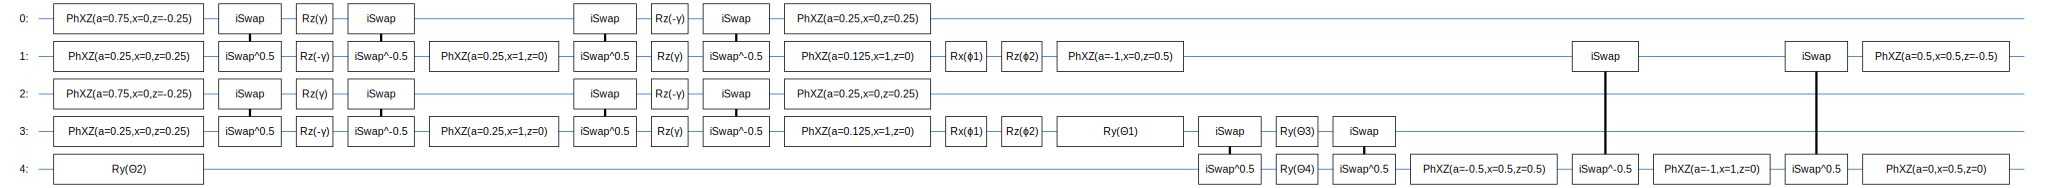

In [40]:
# Representing Circuit:
q = cirq.LineQubit.range(5)
c = cirq.Circuit()
state_symbols = [[Symbol("Θ1"), Symbol("Θ2")], [Symbol("Θ3"), Symbol("Θ4")]]
env_symbols = [Symbol("γ"), Symbol("ϕ1"), Symbol("ϕ2")]
c.append([
    V(env_symbols)(*q[2:4]),
    ParametrisedCircuit(2, state_symbols)(*q[3:5]),
    V(env_symbols)(*q[0:2]),
    cirq.CNOT(q[4],q[1])
])


%store circuit_to_svg(cirq.google.optimized_for_sycamore(c)) >represent.svg
SVGCircuit(cirq.google.optimized_for_sycamore(c))

### Optimization

 - Finding the ground state of the Transverse Field Ising Hamiltonian 

Writing 'circuit_to_svg(cirq.google.optimized_for_sycamore(c))' (str) to file 'optimizeIX.svg'.


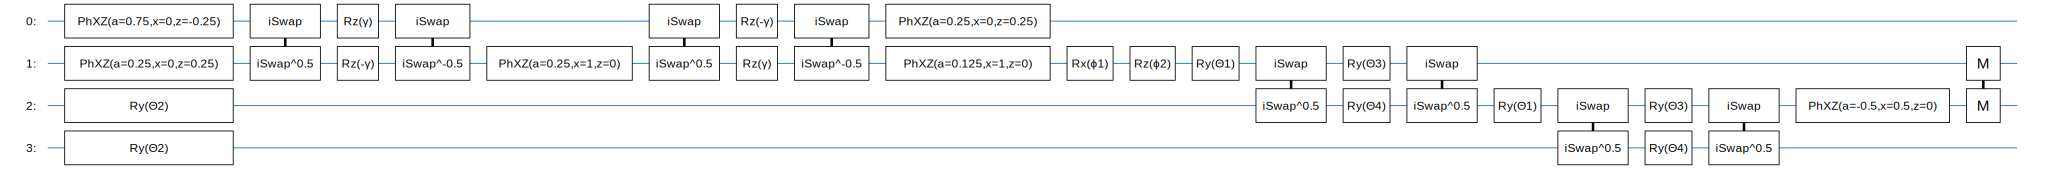

In [39]:
# Optimising Circuit:
q = cirq.LineQubit.range(4)
c = cirq.Circuit()
state_symbols = [[Symbol("Θ1"), Symbol("Θ2")], [Symbol("Θ3"), Symbol("Θ4")]]
env_symbols = [Symbol("γ"), Symbol("ϕ1"), Symbol("ϕ2")]
J,g, α, ξ1, ξ2 = [Symbol("J"), Symbol("g"), Symbol("α"), Symbol("ξ1"), Symbol("ξ2")]
c.append([
    V(env_symbols)(*q[0:2]),
    ParametrisedCircuit(2, state_symbols)(*q[1:3]),
    ParametrisedCircuit(2, state_symbols)(*q[2:4]),
    cirq.H(q[2]),
    cirq.measure(*q[1:3])
])

%store circuit_to_svg(cirq.google.optimized_for_sycamore(c)) >optimizeIX.svg
SVGCircuit(cirq.google.optimized_for_sycamore(c))

### Time evolution 

 - Determining Loschmidt Echoes

Writing 'circuit_to_svg(cirq.google.optimized_for_sycamore(c))' (str) to file 'timeevo.svg'.


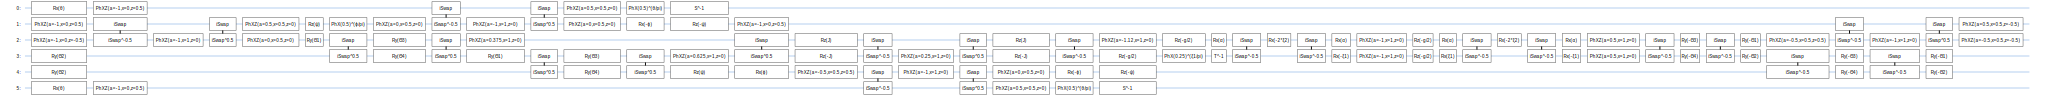

In [47]:
# Optimising Circuit:
q = cirq.LineQubit.range(6)
c = cirq.Circuit()
state_symbols = [[Symbol("Θ1"), Symbol("Θ2")], [Symbol("Θ3"), Symbol("Θ4")]]
env_symbols = [Symbol("θ"), Symbol("ψ"), Symbol("ϕ")]
J,g, α, ξ1, ξ2 = [Symbol("J"), Symbol("g"), Symbol("α"), Symbol("ξ1"), Symbol("ξ2")]
c.append([
    cirq.H(q[2]),
    cirq.CNOT(q[2],q[1]),
    ParametrisedCircuit(2, state_symbols)(*q[2:4]),
    ParametrisedCircuit(2, state_symbols)(*q[3:5]),
    TFIM(J,g,α,ξ1,ξ2)(*q[2:4]),
    RightEnvironment(env_symbols).on(*q[0:2]),
    RightEnvironment(env_symbols).on(*[q[5],q[4]]),
    cirq.inverse(ParametrisedCircuit(2, state_symbols)(*q[2:4])),
    cirq.inverse(ParametrisedCircuit(2, state_symbols)(*q[3:5])),
    cirq.CNOT(q[2],q[1]),
    cirq.H(q[2])
])


%store circuit_to_svg(cirq.google.optimized_for_sycamore(c)) >timeevo.svg
SVGCircuit(cirq.google.optimized_for_sycamore(c))